# Imports

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# prophet
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.make_holidays import make_holidays_df
from prophet.serialize import model_to_json
from prophet.plot import *

import time # para medir o tempo de execução
import itertools # para iterar sobre todos os parâmetros

# warnings
import warnings
warnings.filterwarnings('ignore')

from utils import *

/Users/viniplima/Documents/data/projects/pos_tech_projects/ibovespa_forecasting/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dados

In [2]:
df = pd.read_parquet('output/multi_df.parquet')

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5703 entries, 2001-01-02 to 2024-01-16
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   close          5703 non-null   float64
 1   open           5703 non-null   float64
 2   itau_pn        5703 non-null   float64
 3   pib_per_capta  5703 non-null   float64
 4   vale           5703 non-null   float64
 5   sp500          5701 non-null   float64
 6   nikkei         5701 non-null   float64
 7   selic          5703 non-null   float64
dtypes: float64(8)
memory usage: 401.0 KB


In [3]:
# verificar zeros em qualquer coluna
(df == 0).any().sum()

0

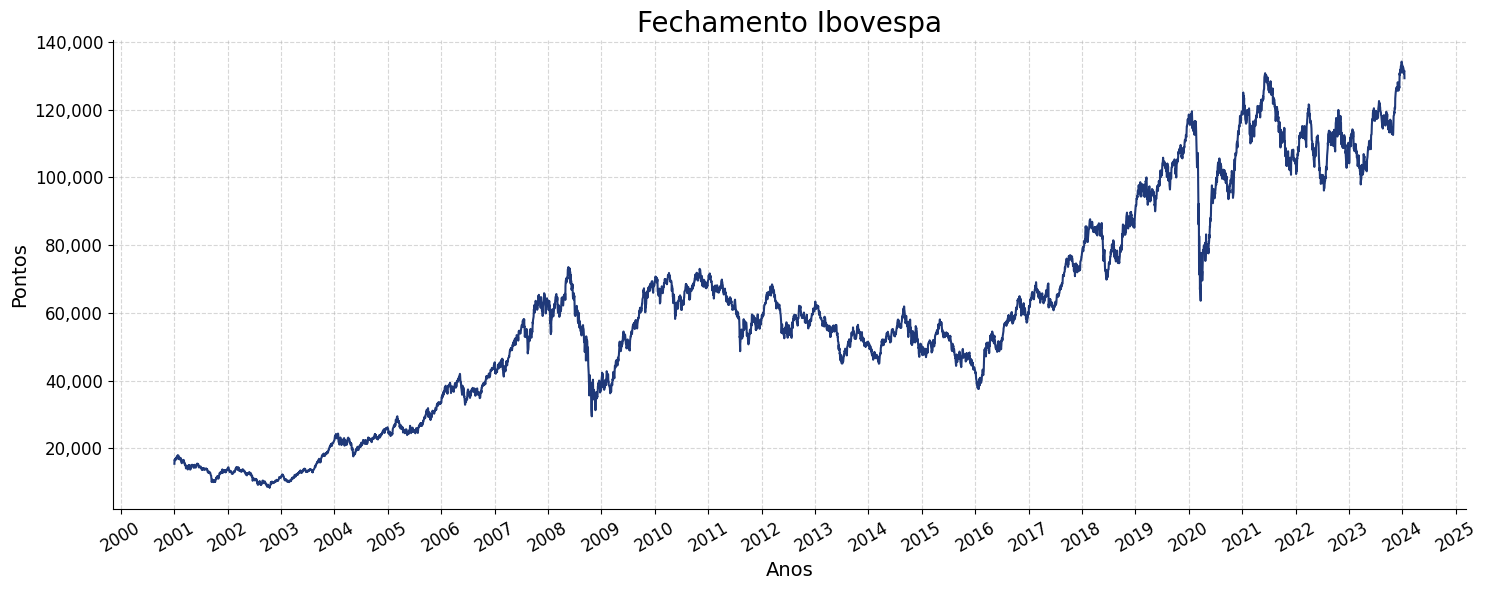

In [4]:
# plotar fechamento
plot_series(df, 'close', title='Fechamento Ibovespa', ylabel='Pontos', xlabel='Anos')

In [5]:
# coluna que não é 'close' => regressor
regressors = [col for col in df.columns if col!='close']

regressors_df = df[regressors].copy()

df = transform_prophet(df, 'close', regressors)

df.head()

,ds,y,open,itau_pn,pib_per_capta,vale,sp500,nikkei,selic
0,2001-01-02,15425.0,15242.0,2.963864,7467.03,3.600000,1333.339966,13691.490234,15.75
1,2001-01-03,16599.0,15425.0,3.079935,7467.03,3.833333,1333.339966,13691.490234,15.75
2,2001-01-04,16675.0,16597.0,3.129443,7467.03,3.708333,1333.339966,13691.490234,15.75
3,2001-01-05,16410.0,16679.0,3.145835,7467.03,3.666666,1298.349976,13867.610352,15.75
4,2001-01-08,16562.0,16398.0,3.079769,7467.03,3.625000,1300.800049,13610.509766,15.75


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5703 entries, 0 to 5702
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   ds             5703 non-null   datetime64[ns]
 1   y              5703 non-null   float64       
 2   open           5703 non-null   float64       
 3   itau_pn        5703 non-null   float64       
 4   pib_per_capta  5703 non-null   float64       
 5   vale           5703 non-null   float64       
 6   sp500          5701 non-null   float64       
 7   nikkei         5701 non-null   float64       
 8   selic          5703 non-null   float64       
dtypes: datetime64[ns](1), float64(8)
memory usage: 401.1 KB


In [7]:
# train test split -> início: 01/01/2003, fim: 01/06/2020
train = df[(df.ds >= '2003-01-01') & (df.ds < '2020-05-01')].copy()
test = df[df.ds >= '2020-05-01'].copy()

print(f'Treino: {len(train)}')
print(f'Teste: {len(test)}')
print(f'% teste: {len(test)/len(df):.2%}')

Treino: 4287
Teste: 922
% teste: 16.17%


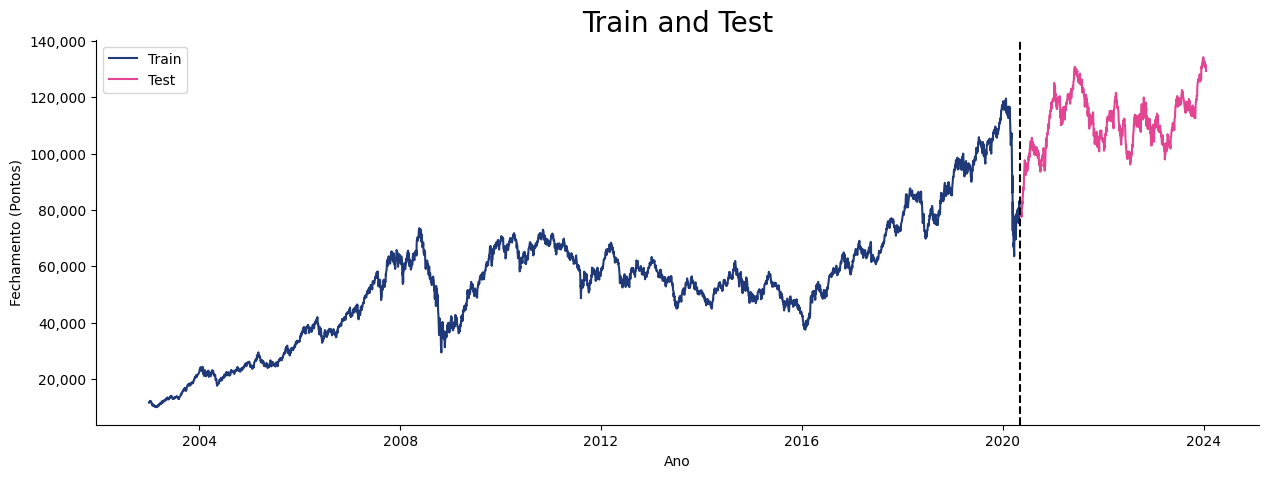

In [8]:
# plot train and test
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(train['ds'], train['y'], label='Train', color='#1f3979')
ax.plot(test['ds'], test['y'], label='Test', color='#e34592')
ax.set_title('Train and Test', fontsize=20)
ax.set_xlabel('Ano')
ax.set_ylabel('Fechamento (Pontos)')
ax.axvline(x=test['ds'].min(), color='black', linestyle='--')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend();

# Baseline Model

00:08:48 - cmdstanpy - INFO - Chain [1] start processing
00:08:49 - cmdstanpy - INFO - Chain [1] done processing


MAPE: 21.03%


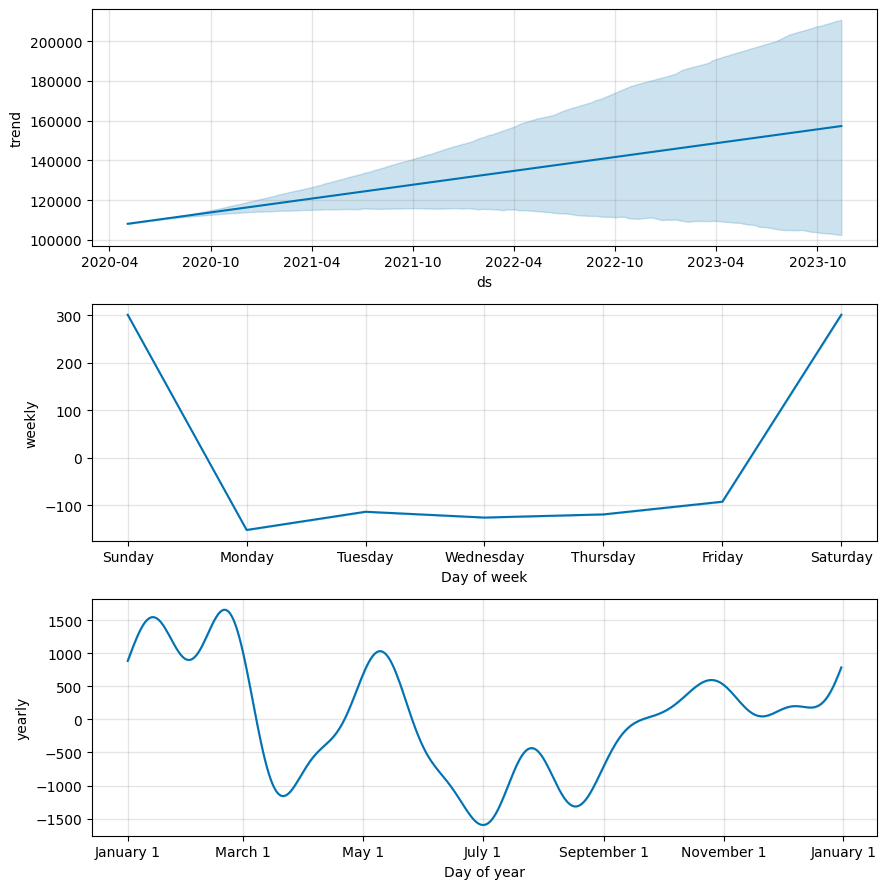

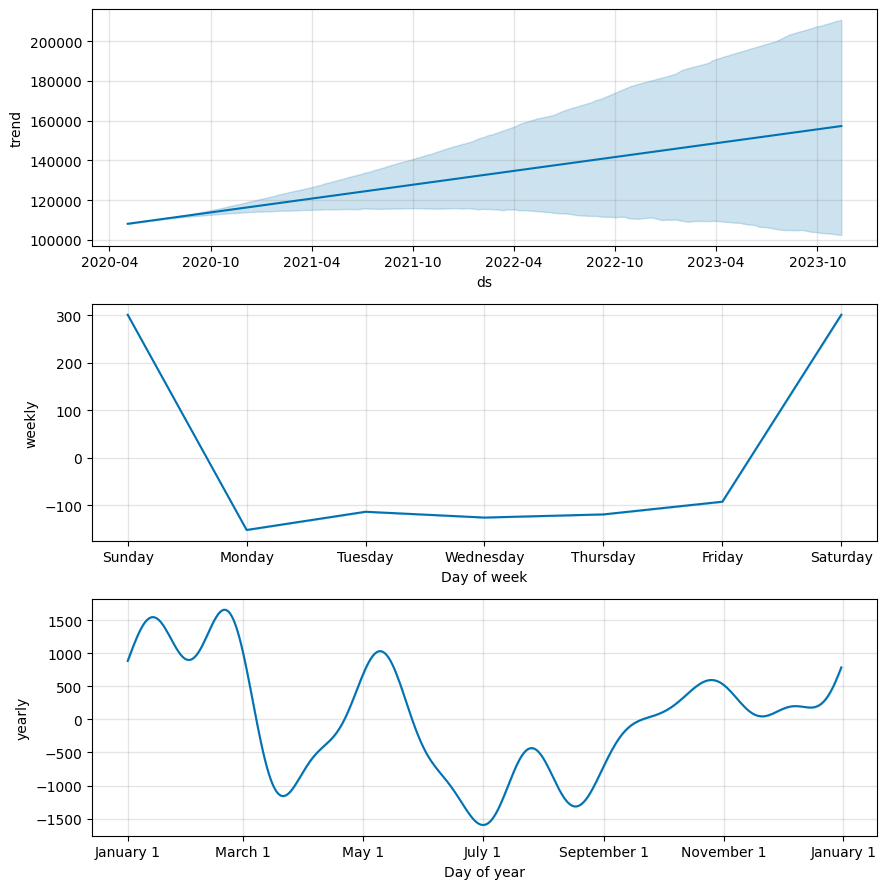

In [9]:
# baseline model
baseline_model = Prophet() # parâmetros default
baseline_model.fit(train)

# predizer test set
future_baseline = baseline_model.make_future_dataframe(periods=len(test),
                                                        freq='B') # dias úteis
forecast_baseline = baseline_model.predict(future_baseline)
# calular mape
forecast_baseline = forecast_baseline.merge(test[['ds', 'y']], on='ds')
# calcular mape média
forecast_baseline['mape'] = np.abs((forecast_baseline['yhat'] - forecast_baseline['y']) / forecast_baseline['y'])
print(f'MAPE: {forecast_baseline.mape.mean():.2%}')

# plotar baseline
fig = plot_plotly(baseline_model, forecast_baseline)
fig.update_layout(title='Baseline Model')
fig.show()

# plotar componentes
baseline_model.plot_components(forecast_baseline)

In [10]:
# cross validation
df_cv_baseline = cross_validation(baseline_model,
                                    initial='200 days',
                                    period='60 days',
                                    horizon='30 days')

# aplicar performance metrics para avaliar o modelo
df_p_baseline = performance_metrics(df_cv_baseline)

df_p_baseline.head(30)

Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/102 [00:00<?, ?it/s]00:08:52 - cmdstanpy - INFO - Chain [1] start processing
00:08:52 - cmdstanpy - INFO - Chain [1] done processing
00:08:52 - cmdstanpy - INFO - Chain [1] start processing
00:08:52 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 2/102 [00:00<00:09, 10.09it/s]00:08:52 - cmdstanpy - INFO - Chain [1] start processing
00:08:52 - cmdstanpy - INFO - Chain [1] done processing
00:08:52 - cmdstanpy - INFO - Chain [1] start processing
00:08:52 - cmdstanpy - INFO - Chain [1] done processing
  4%|▍         | 4/102 [00:00<00:10,  9.49it/s]00:08:52 - cmdstanpy - INFO - Chain [1] start processing
00:08:53 - cmdstanpy - INFO - Chain [1] done processing
  5%|▍         | 5/102 [00:00<00:11,  8.23it/s]00:08:53 - cmdstanpy - INFO - Chain [1] start processing
00:08:53 - cmdstanpy - INFO - Chain [1] done processing
  6%|▌         | 6/102 [00:00<00:12,  

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,4 days,5.624985e+07,7499.989958,5087.195393,0.090653,0.062300,0.090194,0.400628
1,5 days,4.892156e+07,6994.394840,4933.378902,0.088690,0.063132,0.088962,0.397712
2,6 days,4.774868e+07,6910.041921,4890.794814,0.088332,0.065978,0.088647,0.433868
3,7 days,5.649483e+07,7516.304469,5157.646593,0.092559,0.067047,0.092919,0.429265
4,8 days,6.343293e+07,7964.479288,5388.543177,0.096300,0.069969,0.096540,0.401682
5,9 days,6.467020e+07,8041.778366,5543.687597,0.099986,0.074987,0.100006,0.335088
6,10 days,6.278638e+07,7923.785443,5664.914653,0.104497,0.085655,0.104177,0.281006
7,11 days,5.771684e+07,7597.160015,5605.220558,0.104183,0.086575,0.105179,0.255804
8,12 days,4.966987e+07,7047.685607,5299.553437,0.098626,0.084963,0.100199,0.285262
9,13 days,5.252154e+07,7247.174767,5259.668444,0.096547,0.074835,0.097844,0.329827


# Modelo Final

In [11]:
years = df.ds.dt.year.unique()

# feriados - ibovespa: índice de fechamento da bolsa de valores de são paulo
sp_holidays = make_holidays_df(
    year_list=years,
    country='BR', province='SP',
    
)

# usar também os feriados nacionais
br_holidays = make_holidays_df(
    year_list=years,
    country='BR',
)

In [12]:
# descoberta do pré-sal pela Petrobrás, em 2006
pre_sal = pd.DataFrame({
    'holiday': 'Descoberta Pré-sal',
    'ds': pd.to_datetime(['2006-01-01']),
    'df_upper': '2007-12-31',
    'lower_window': 0,
    'upper_window': 0,
    })

crise_2008 = pd.DataFrame({
    'holiday': 'Crise Financeira 2008',
    'ds': pd.to_datetime(['2008-09-15']),
    'df_upper': '2009-06-15',
    'lower_window': -5,
    'upper_window':0,
    })

impeachment = pd.DataFrame({
    'holiday': 'Impeachment 2014',
    'ds': pd.to_datetime(['2014-03-01']),
    'df_upper': '2016-05-31',
    'lower_window': -5,
    'upper_window': 5,
    })

pandemia = pd.DataFrame({
    'holiday': 'Pandemia',
    'ds': pd.to_datetime(['2020-03-11']),
    'df_upper': '2021-08-16',
    'lower_window': -5,
    'upper_window': 5,
    })

pre_sal, crise_2008, impeachment, pandemia

(              holiday         ds    df_upper  lower_window  upper_window
 0  Descoberta Pré-sal 2006-01-01  2007-12-31             0             0,
                  holiday         ds    df_upper  lower_window  upper_window
 0  Crise Financeira 2008 2008-09-15  2009-06-15            -5             0,
             holiday         ds    df_upper  lower_window  upper_window
 0  Impeachment 2014 2014-03-01  2016-05-31            -5             5,
     holiday         ds    df_upper  lower_window  upper_window
 0  Pandemia 2020-03-11  2021-08-16            -5             5)

In [13]:
# eleições a cada 4 anos, a partir de 2002
anos_eleicoes = np.arange(2002, 2026, 4)
dia_mes = ['10-04'] * len(anos_eleicoes)
datas_eleicoes = [f'{ano}-{dia}' for ano, dia in zip(anos_eleicoes, dia_mes)]

eleicoes = pd.DataFrame({
    'holiday': 'Eleição Presidencial',
    'ds': pd.to_datetime(datas_eleicoes),
    'lower_window': -3,
    'upper_window': 4,
    })

eleicoes

,holiday,ds,lower_window,upper_window
0,Eleição Presidencial,2002-10-04,-3,4
1,Eleição Presidencial,2006-10-04,-3,4
2,Eleição Presidencial,2010-10-04,-3,4
3,Eleição Presidencial,2014-10-04,-3,4
4,Eleição Presidencial,2018-10-04,-3,4
5,Eleição Presidencial,2022-10-04,-3,4


In [14]:
# juntar dataframes
holidays_df = pd.concat([sp_holidays, br_holidays, 
                        pre_sal, crise_2008, pandemia, impeachment, eleicoes])
holidays_df.drop_duplicates(inplace=True)

holidays_df.upper_window.fillna(4, inplace=True)
holidays_df.lower_window.fillna(-3, inplace=True)

holidays_df.head()

,ds,holiday,df_upper,lower_window,upper_window
0,2001-01-01,Confraternização Universal,NaN,-3.0,4.0
1,2001-04-13,Sexta-feira Santa,NaN,-3.0,4.0
2,2001-04-21,Tiradentes,NaN,-3.0,4.0
3,2001-05-01,Dia do Trabalhador,NaN,-3.0,4.0
4,2001-09-07,Independência do Brasil,NaN,-3.0,4.0


In [15]:
help(Prophet)

Help on class Prophet in module prophet.forecaster:

class Prophet(builtins.object)
 |  Prophet(growth='linear', changepoints=None, n_changepoints=25, changepoint_range=0.8, yearly_seasonality='auto', weekly_seasonality='auto', daily_seasonality='auto', holidays=None, seasonality_mode='additive', seasonality_prior_scale=10.0, holidays_prior_scale=10.0, changepoint_prior_scale=0.05, mcmc_samples=0, interval_width=0.8, uncertainty_samples=1000, stan_backend=None, scaling: str = 'absmax', holidays_mode=None)
 |  
 |  Prophet forecaster.
 |  
 |  Parameters
 |  ----------
 |  growth: String 'linear', 'logistic' or 'flat' to specify a linear, logistic or
 |      flat trend.
 |  changepoints: List of dates at which to include potential changepoints. If
 |      not specified, potential changepoints are selected automatically.
 |  n_changepoints: Number of potential changepoints to include. Not used
 |      if input `changepoints` is supplied. If `changepoints` is not supplied,
 |      then n_

In [16]:
starts_time = time.time()
dicts = {}

# opções a serem testadas
param_grid = {
        'changepoint_range': [0.8, 0.95],
        'changepoint_prior_scale': [0.01, 0.5],
        'holidays_prior_scale': [0.5, 10],
    }

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

for params in all_params:
    # utilizar datas importantes em todos os modelos
    m = Prophet(**params, holidays=holidays_df)
    # adicionar regressores
    for regressor in regressors:
        m.add_regressor(regressor)
    m.fit(train)
    # cross validation para o período de 30 dias
    df_cv = cross_validation(m, initial='200 days', period='30 days', horizon='30 days')
    df_p = performance_metrics(df_cv, rolling_window=1)
    print(df_p)
    # obter valores para MAPE e RMSE
    mapes = df_p['mape'].values
    rmses = df_p['rmse'].values
    # criar um dataframe com os resultados de cada modelo
    tuning_results = pd.DataFrame([params])
    tuning_results['mape'] = mapes
    tuning_results['rmse'] = rmses
    print(tuning_results.head())
    # dicionário para guardar o melhor modelo
    param_dict = tuning_results.sort_values('mape').iloc[0, :].to_dict()
    dicts.update({param_dict['mape']: param_dict})

print(f'Tempo de execução: {time.time() - starts_time}')

00:10:45 - cmdstanpy - INFO - Chain [1] start processing
00:10:52 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/204 [00:00<?, ?it/s]00:10:53 - cmdstanpy - INFO - Chain [1] start processing
00:10:53 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 1/204 [00:00<02:02,  1.65it/s]00:10:54 - cmdstanpy - INFO - Chain [1] start processing
00:10:54 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 2/204 [00:01<01:59,  1.69it/s]00:10:54 - cmdstanpy - INFO - Chain [1] start processing
00:10:54 - cmdstanpy - INFO - Chain [1] done processing
  1%|▏         | 3/204 [00:01<02:07,  1.57it/s]00:10:55 - cmdstanpy - INFO - Chain [1] start processing
00:10:55 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 4/204 [00:02<02:15,  1.48it/s]00:10:56 - cmdstanpy - INFO - Chain [1] start processing
00:10:56 - cmdstanpy - INFO - Chain [1] done pr

  horizon           mse         rmse         mae      mape     mdape  \
0 30 days  1.254261e+06  1119.938139  801.329323  0.016535  0.011246   

      smape  coverage  
0  0.016605  0.545718  
   changepoint_range  changepoint_prior_scale  holidays_prior_scale      mape  \
0                0.8                     0.01                   0.5  0.016535   

          rmse  
0  1119.938139  


00:21:17 - cmdstanpy - INFO - Chain [1] start processing
00:21:22 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/204 [00:00<?, ?it/s]00:21:23 - cmdstanpy - INFO - Chain [1] start processing
00:21:23 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 1/204 [00:00<01:56,  1.74it/s]00:21:24 - cmdstanpy - INFO - Chain [1] start processing
00:21:24 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 2/204 [00:01<01:59,  1.70it/s]00:21:24 - cmdstanpy - INFO - Chain [1] start processing
00:21:24 - cmdstanpy - INFO - Chain [1] done processing
  1%|▏         | 3/204 [00:01<01:58,  1.70it/s]00:21:25 - cmdstanpy - INFO - Chain [1] start processing
00:21:25 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 4/204 [00:02<01:58,  1.69it/s]00:21:26 - cmdstanpy - INFO - Chain [1] start processing
00:21:26 - cmdstanpy - INFO - Chain [1] done pr

  horizon           mse        rmse         mae      mape     mdape    smape  \
0 30 days  1.282703e+06  1132.56462  807.198465  0.016886  0.011187  0.01692   

   coverage  
0  0.551025  
   changepoint_range  changepoint_prior_scale  holidays_prior_scale      mape  \
0                0.8                     0.01                    10  0.016886   

         rmse  
0  1132.56462  


00:31:39 - cmdstanpy - INFO - Chain [1] start processing
00:31:50 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/204 [00:00<?, ?it/s]00:31:51 - cmdstanpy - INFO - Chain [1] start processing
00:31:51 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 1/204 [00:00<03:05,  1.10it/s]00:31:52 - cmdstanpy - INFO - Chain [1] start processing
00:31:52 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 2/204 [00:01<03:17,  1.02it/s]00:31:53 - cmdstanpy - INFO - Chain [1] start processing
00:31:53 - cmdstanpy - INFO - Chain [1] done processing
  1%|▏         | 3/204 [00:03<03:31,  1.05s/it]00:31:54 - cmdstanpy - INFO - Chain [1] start processing
00:31:54 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 4/204 [00:04<03:38,  1.09s/it]00:31:55 - cmdstanpy - INFO - Chain [1] start processing
00:31:56 - cmdstanpy - INFO - Chain [1] done pr

  horizon           mse         rmse          mae      mape     mdape  \
0 30 days  4.385495e+06  2094.157252  1009.184324  0.025869  0.013221   

      smape  coverage  
0  0.026098  0.444391  
   changepoint_range  changepoint_prior_scale  holidays_prior_scale      mape  \
0                0.8                      0.5                   0.5  0.025869   

          rmse  
0  2094.157252  


00:54:46 - cmdstanpy - INFO - Chain [1] start processing
00:54:59 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/204 [00:00<?, ?it/s]00:55:00 - cmdstanpy - INFO - Chain [1] start processing
00:55:00 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 1/204 [00:00<03:09,  1.07it/s]00:55:01 - cmdstanpy - INFO - Chain [1] start processing
00:55:01 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 2/204 [00:01<03:17,  1.02it/s]00:55:02 - cmdstanpy - INFO - Chain [1] start processing
00:55:02 - cmdstanpy - INFO - Chain [1] done processing
  1%|▏         | 3/204 [00:03<03:30,  1.05s/it]00:55:03 - cmdstanpy - INFO - Chain [1] start processing
00:55:03 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 4/204 [00:04<03:32,  1.06s/it]00:55:04 - cmdstanpy - INFO - Chain [1] start processing
00:55:05 - cmdstanpy - INFO - Chain [1] done pr

  horizon           mse         rmse         mae      mape     mdape    smape  \
0 30 days  4.495359e+06  2120.226249  1011.96406  0.026025  0.013104  0.02622   

   coverage  
0  0.443426  
   changepoint_range  changepoint_prior_scale  holidays_prior_scale      mape  \
0                0.8                      0.5                    10  0.026025   

          rmse  
0  2120.226249  


01:18:04 - cmdstanpy - INFO - Chain [1] start processing
01:18:12 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/204 [00:00<?, ?it/s]01:18:14 - cmdstanpy - INFO - Chain [1] start processing
01:18:14 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 1/204 [00:00<02:03,  1.64it/s]01:18:14 - cmdstanpy - INFO - Chain [1] start processing
01:18:14 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 2/204 [00:01<02:02,  1.65it/s]01:18:15 - cmdstanpy - INFO - Chain [1] start processing
01:18:15 - cmdstanpy - INFO - Chain [1] done processing
  1%|▏         | 3/204 [00:01<02:00,  1.66it/s]01:18:15 - cmdstanpy - INFO - Chain [1] start processing
01:18:15 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 4/204 [00:02<02:01,  1.65it/s]01:18:16 - cmdstanpy - INFO - Chain [1] start processing
01:18:16 - cmdstanpy - INFO - Chain [1] done pr

  horizon           mse         rmse        mae      mape     mdape     smape  \
0 30 days  1.082564e+06  1040.463589  732.95635  0.015747  0.010076  0.015768   

   coverage  
0  0.591074  
   changepoint_range  changepoint_prior_scale  holidays_prior_scale      mape  \
0               0.95                     0.01                   0.5  0.015747   

          rmse  
0  1040.463589  


01:28:20 - cmdstanpy - INFO - Chain [1] start processing
01:28:26 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/204 [00:00<?, ?it/s]01:28:27 - cmdstanpy - INFO - Chain [1] start processing
01:28:27 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 1/204 [00:00<01:52,  1.80it/s]01:28:28 - cmdstanpy - INFO - Chain [1] start processing
01:28:28 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 2/204 [00:01<01:52,  1.80it/s]01:28:28 - cmdstanpy - INFO - Chain [1] start processing
01:28:28 - cmdstanpy - INFO - Chain [1] done processing
  1%|▏         | 3/204 [00:01<01:52,  1.79it/s]01:28:29 - cmdstanpy - INFO - Chain [1] start processing
01:28:29 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 4/204 [00:02<01:52,  1.78it/s]01:28:29 - cmdstanpy - INFO - Chain [1] start processing
01:28:29 - cmdstanpy - INFO - Chain [1] done pr

  horizon           mse         rmse        mae      mape     mdape     smape  \
0 30 days  1.085686e+06  1041.962583  733.15584  0.015785  0.010083  0.015803   

   coverage  
0  0.589385  
   changepoint_range  changepoint_prior_scale  holidays_prior_scale      mape  \
0               0.95                     0.01                    10  0.015785   

          rmse  
0  1041.962583  


01:37:53 - cmdstanpy - INFO - Chain [1] start processing
01:38:03 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/204 [00:00<?, ?it/s]01:38:04 - cmdstanpy - INFO - Chain [1] start processing
01:38:04 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 1/204 [00:00<02:52,  1.18it/s]01:38:05 - cmdstanpy - INFO - Chain [1] start processing
01:38:05 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 2/204 [00:01<03:01,  1.11it/s]01:38:06 - cmdstanpy - INFO - Chain [1] start processing
01:38:06 - cmdstanpy - INFO - Chain [1] done processing
  1%|▏         | 3/204 [00:02<03:14,  1.03it/s]01:38:07 - cmdstanpy - INFO - Chain [1] start processing
01:38:08 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 4/204 [00:03<03:25,  1.03s/it]01:38:08 - cmdstanpy - INFO - Chain [1] start processing
01:38:08 - cmdstanpy - INFO - Chain [1] done pr

  horizon           mse         rmse         mae      mape     mdape  \
0 30 days  3.590852e+06  1894.954277  928.004681  0.023959  0.012084   

      smape  coverage  
0  0.024679  0.479373  
   changepoint_range  changepoint_prior_scale  holidays_prior_scale      mape  \
0               0.95                      0.5                   0.5  0.023959   

          rmse  
0  1894.954277  


01:56:38 - cmdstanpy - INFO - Chain [1] start processing
01:56:47 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.
  0%|          | 0/204 [00:00<?, ?it/s]01:56:48 - cmdstanpy - INFO - Chain [1] start processing
01:56:48 - cmdstanpy - INFO - Chain [1] done processing
  0%|          | 1/204 [00:00<02:50,  1.19it/s]01:56:49 - cmdstanpy - INFO - Chain [1] start processing
01:56:49 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 2/204 [00:01<03:10,  1.06it/s]01:56:50 - cmdstanpy - INFO - Chain [1] start processing
01:56:50 - cmdstanpy - INFO - Chain [1] done processing
  1%|▏         | 3/204 [00:02<03:17,  1.02it/s]01:56:51 - cmdstanpy - INFO - Chain [1] start processing
01:56:52 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 4/204 [00:04<03:27,  1.04s/it]01:56:52 - cmdstanpy - INFO - Chain [1] start processing
01:56:53 - cmdstanpy - INFO - Chain [1] done pr

  horizon           mse        rmse         mae      mape     mdape     smape  \
0 30 days  3.578569e+06  1891.71055  923.577464  0.023653  0.012074  0.024274   

   coverage  
0  0.477443  
   changepoint_range  changepoint_prior_scale  holidays_prior_scale      mape  \
0               0.95                      0.5                    10  0.023653   

         rmse  
0  1891.71055  
Tempo de execução: 7478.796938896179


In [17]:
# selecionar melhores parâmetros
best_params = {k:v for k, v in param_dict.items() if k not in ['mape', 'rmse']}

# criar modelo a partir dos melhores parâmetros
best_model = Prophet(**best_params, holidays=holidays_df)
# adicionar regressores ao modelo
for regressor in regressors:
    best_model.add_regressor(regressor)
best_model.fit(train)

# salvar modelo com prophet
with open('output/ibovespa_forecasting.json', 'w') as fout:
    fout.write(model_to_json(best_model))

02:15:23 - cmdstanpy - INFO - Chain [1] start processing
02:15:32 - cmdstanpy - INFO - Chain [1] done processing


In [33]:
# cross validation
df_cv = cross_validation(best_model, initial='700 days', period='60 days', horizon='30 days')
# performance metrics
df_p = performance_metrics(df_cv)

df_p.head()

  0%|          | 0/94 [00:00<?, ?it/s]11:00:26 - cmdstanpy - INFO - Chain [1] start processing
11:00:27 - cmdstanpy - INFO - Chain [1] done processing
  1%|          | 1/94 [00:02<03:38,  2.35s/it]11:00:28 - cmdstanpy - INFO - Chain [1] start processing
11:00:29 - cmdstanpy - INFO - Chain [1] done processing
  2%|▏         | 2/94 [00:04<03:24,  2.22s/it]11:00:30 - cmdstanpy - INFO - Chain [1] start processing
11:00:32 - cmdstanpy - INFO - Chain [1] done processing
  3%|▎         | 3/94 [00:06<03:23,  2.24s/it]11:00:32 - cmdstanpy - INFO - Chain [1] start processing
11:00:34 - cmdstanpy - INFO - Chain [1] done processing
  4%|▍         | 4/94 [00:09<03:34,  2.38s/it]11:00:35 - cmdstanpy - INFO - Chain [1] start processing
11:00:36 - cmdstanpy - INFO - Chain [1] done processing
  5%|▌         | 5/94 [00:10<03:00,  2.03s/it]11:00:36 - cmdstanpy - INFO - Chain [1] start processing
11:00:38 - cmdstanpy - INFO - Chain [1] done processing
  6%|▋         | 6/94 [00:12<03:02,  2.07s/it]11:00:39

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,4 days,619282.512256,786.945050,593.572774,0.010151,0.008566,0.010153,0.645671
1,5 days,648769.891012,805.462532,620.883303,0.010851,0.009231,0.010854,0.590526
2,6 days,554406.948634,744.585085,597.592879,0.010491,0.009641,0.010495,0.608020
3,7 days,542917.348628,736.829253,595.650099,0.010492,0.009412,0.010488,0.608826
4,8 days,545375.725615,738.495583,592.493786,0.010326,0.009739,0.010321,0.616268


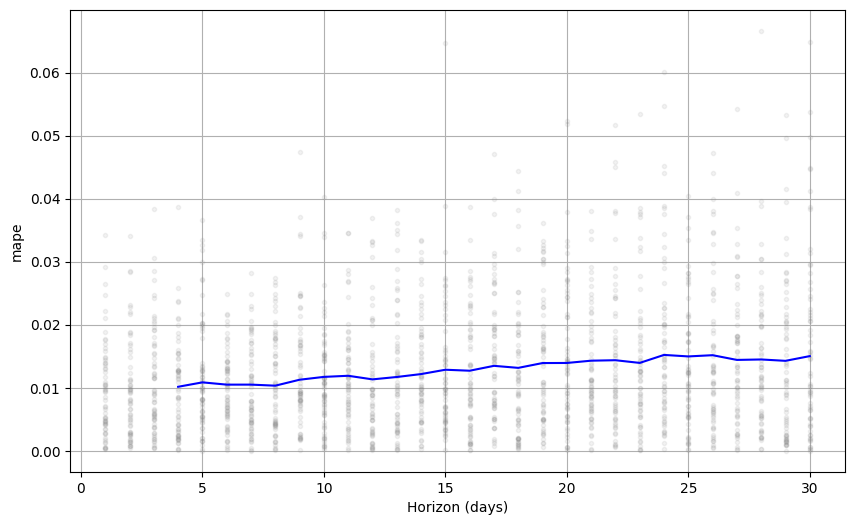

In [72]:
# plotar mape
fig = plot_cross_validation_metric(df_cv, metric='mape')
fig.show()

MAPE: 5.04%


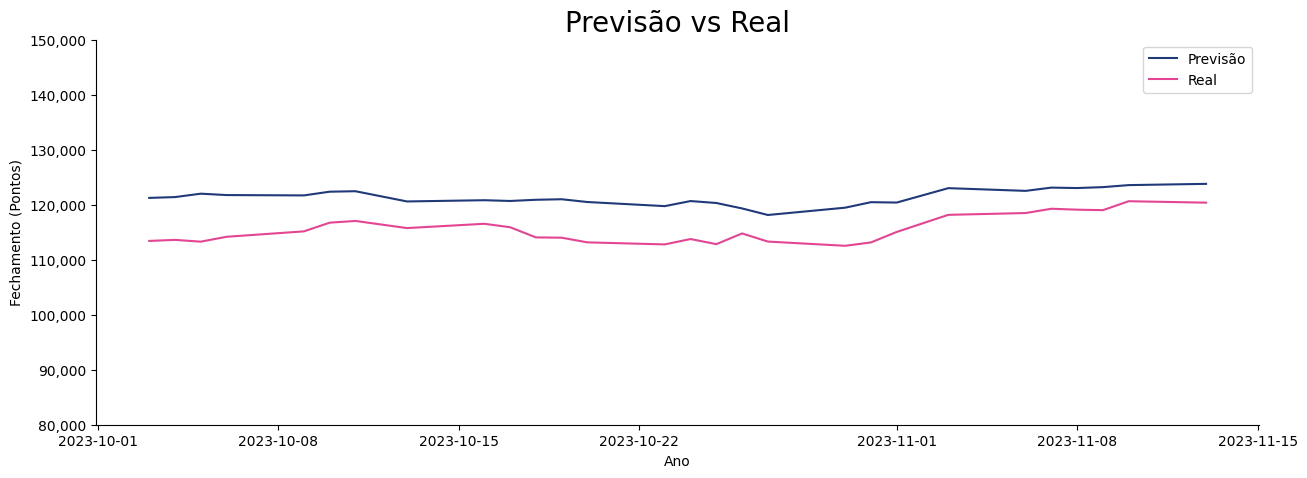

In [70]:
# backtesting - previsão para o período de teste
future = best_model.make_future_dataframe(periods=len(test), freq='B')

# apenas os últimos 30 dias
period = 30
future = future.iloc[-period:, :]

# adicionar regressores
for regressor in regressors:
    future[regressor] = df[regressor]

# prever
forecast = best_model.predict(future)

# calcular mape
forecast = forecast.merge(test[['ds', 'y']], on='ds')
forecast['mape'] = np.abs((forecast['yhat'] - forecast['y']) / forecast['y'])
print(f'MAPE: {forecast.mape.mean():.2%}')

# plotar previsão com seaborn, apenas 30 dias
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(forecast['ds'], forecast['yhat'], label='Previsão', color='#1f3979')
ax.plot(forecast['ds'], forecast['y'], label='Real', color='#e34592')
ax.set_title('Previsão vs Real', fontsize=20)
ax.set_xlabel('Ano')
ax.set_ylabel('Fechamento (Pontos)')
ax.set_ylim(80000, 150000)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend();